In [7]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt 
import os
import matplotlib.colors as col
import matplotlib as mpl 
from cartopy.util import add_cyclic_point
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
import cartopy.crs as ccrs

from pyClimat.plot_utils import cut_terrain_map
from pyClimat.plots import plot_echam_topo

In [8]:
# declare path to
path_to_ctl = "/home/dboateng/Model_output_pst/Miotopofiles/CTL_Mio_Herold/orography.nc"
path_to_t159 = "/home/dboateng/Model_output_pst/Miotopofiles/CTL_Mio_Herold/jan_surf_files/"
path_to_mio278 = "/home/dboateng/Model_output_pst/Miotopofiles/CTL_Mio278"
path_to_mio450 = "/home/dboateng/Model_output_pst/Miotopofiles/CTL_Mio450"
path_to_store = "/home/dboateng/Model_output_pst/Miotopofiles/CTL_Mio_Herold/"

In [9]:
# load data 
def modify_topo_mio(filename):
    data = xr.open_dataset(path_to_ctl)
    
    
    
    #extract the Alps and its sections
    
    # add western Alps coords
    
    maxlat, minlat, maxlon, minlon = 48, 43, 8, 1
    minelev = 800
    #convert lon to -180 to 180
    #data_z = data_z.assign_coords({"lon": (((data_z.lon + 180) % 360) - 180)})
    
    lat_range = (data.lat >= minlat) & (data.lat <= maxlat)
    lon_range = (data.lon >= minlon) & (data.lon <= maxlon)
    data_extract = np.ones((data.dims["lat"], data.dims["lon"])) * data.where((lat_range & lon_range) & (data.topo >= minelev))
    # add as mask and extract values
    
    data.coords["west_alps_mask"] = (("lat", "lon"), data_extract.topo.data)
    
    data["topo_modify"] = xr.where(np.isnan(data["west_alps_mask"])==False, data["topo"] * 3, data["topo"])
    
    # inrease the eastern Alps a litle to avoid steps
    
    maxlat, minlat, maxlon, minlon = 48, 44, 15, 8
    minelev = 600
    #convert lon to -180 to 180
    #data_z = data_z.assign_coords({"lon": (((data_z.lon + 180) % 360) - 180)})
    
    lat_range = (data.lat >= minlat) & (data.lat <= maxlat)
    lon_range = (data.lon >= minlon) & (data.lon <= maxlon)
    data_extract = np.ones((data.dims["lat"], data.dims["lon"])) * data.where((lat_range & lon_range) & (data.topo >= minelev))
    # add as mask and extract values
    
    data.coords["east_alps_mask"] = (("lat", "lon"), data_extract.topo.data)
    
    if filename == "W2E1_orography.nc":
        
        data["topo_modify"] = xr.where(np.isnan(data["east_alps_mask"])==False, 
                                        data["topo_modify"] + data["topo_modify"] * 0.3 , data["topo_modify"])
        
    elif filename == "W2E0_orography.nc":
        data["topo_modify"] = xr.where(np.isnan(data["east_alps_mask"])==False, 
                                        250 , data["topo_modify"])
        
    elif filename == "W2E1.5_orography.nc":
        data["topo_modify"] = xr.where(np.isnan(data["east_alps_mask"])==False, 
                                        data["topo_modify"] + data["topo_modify"] * 0.9 , data["topo_modify"])
        
    elif filename == "W2E2_orography.nc":
        data["topo_modify"] = xr.where(np.isnan(data["east_alps_mask"])==False, 
                                        data["topo_modify"] * 3, data["topo_modify"])
    
    #save files 
    
    data = data.drop_vars(["topo", "west_alps_mask", "east_alps_mask"])
    data = data.rename({"topo_modify": "topo"})
    data.to_netcdf(os.path.join(path_to_store, filename), format = "NETCDF3_CLASSIC")

In [ ]:
# filenames = ["W2E1_orography.nc", "W2E1.5_orography.nc", "W2E0_orography.nc", "W2E2_orography.nc"]

# for filename in filenames:
#     print ("running for", filename)
#     modify_topo_mio(filename)

In [10]:
def read_jan_surf_oromea(path, filename):
    # plot jan_surf 
    jan_surf = xr.open_dataset(os.path.join(path, filename))   
    oromea = jan_surf.OROMEA
    oromea = xr.where(jan_surf.SLM == 0, -100, oromea)
    
    return oromea

/tmp/ipykernel_229057/1047586640.py:61: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


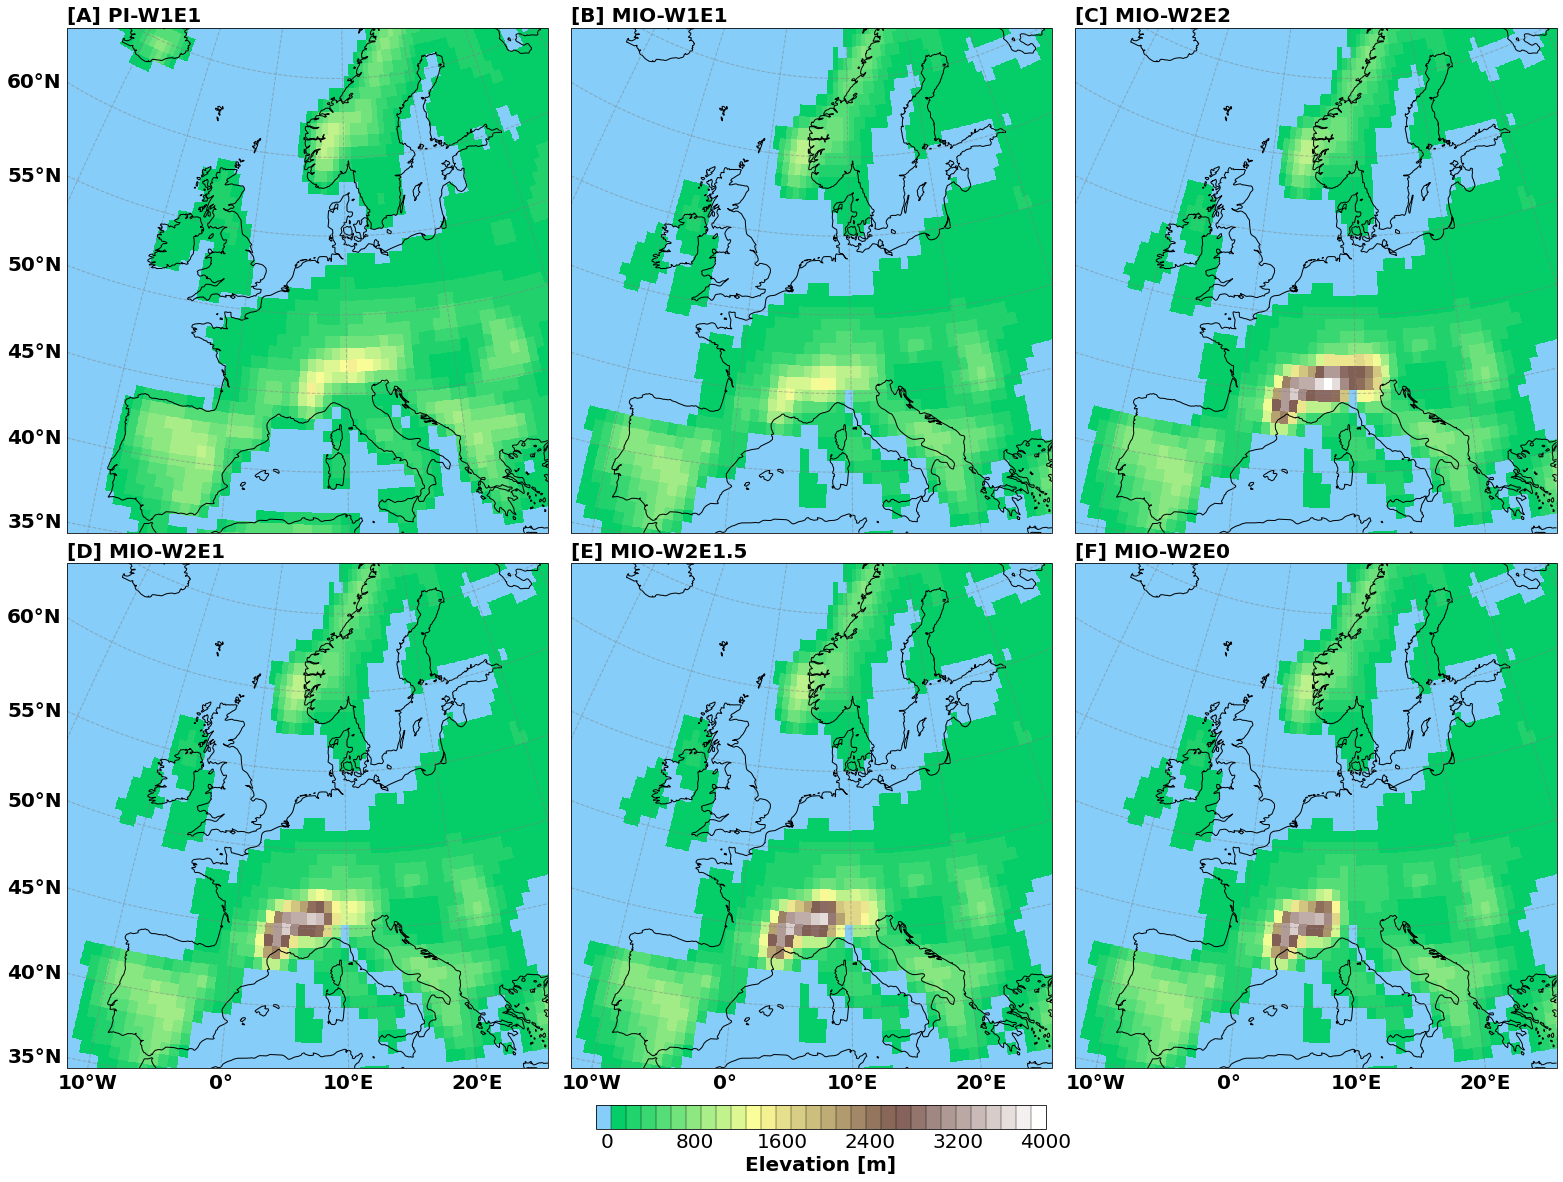

In [11]:
projection = ccrs.EuroPP()
fig, ((ax1,ax2,ax3), (ax4, ax5,ax6)) = plt.subplots(nrows = 2, ncols = 3, figsize=(25, 17), 
                                                    subplot_kw={"projection": projection})

    
levels = [i for i in range(-100, 4000, 100)]
terrain_new = mpl.cm.get_cmap("terrain", 256)
terrain_adjust = ListedColormap(terrain_new(np.linspace(0.23, 1, 256)))
new_colors = terrain_adjust(np.linspace(0,1,256))

blue = np.array([135/256, 206/256, 250/256, 1])
new_colors[:1, :] = blue
terrain_shift = ListedColormap(new_colors)

norm_new = col.BoundaryNorm(levels, ncolors=terrain_shift.N, clip=True)

# plt.subplots(nrows = 1, ncols = 1, figsize=(20, 15), subplot_kw={"projection":projection})
pi_oromea = read_jan_surf_oromea(path_to_t159, "T159_PI_W1E1_jan_surf.nc")
plot_echam_topo(variable="Elevation", data=pi_oromea, cmap=terrain_shift, units="m", 
                vmax=4000, vmin=-100, levels=31, level_ticks=6,
                domain="Europe", cbar=True, cbar_position= [0.35, 0.05, 0.25, 0.02], cbar_orientation="horizontal",
                projection=projection, norm=norm_new, plot_coastlines=True, plot_borders=False, ax=ax1, 
                title="[A] PI-W1E1", bottom_labels=False, fig=fig)

miow1e1_oromea = read_jan_surf_oromea(path_to_t159, "T159_MIO_W1E1_jan_surf_Herold.nc")

plot_echam_topo(variable="Elevation", data=miow1e1_oromea, cmap=terrain_shift, units="m", 
                vmax=4000, vmin=-100, levels=31, level_ticks=6,
                domain="Europe", cbar=False, projection=projection, norm=norm_new, plot_coastlines=True, plot_borders=False, 
                ax=ax2, title="[B] MIO-W1E1", bottom_labels=False, left_labels=False)

miow2e2_oromea = read_jan_surf_oromea(path_to_t159, "T159_MIO_W2E2_jan_surf_Herold.nc")

plot_echam_topo(variable="Elevation", data=miow2e2_oromea, cmap=terrain_shift, units="m", 
                vmax=4000, vmin=-100, levels=31, level_ticks=6,
                domain="Europe", cbar=False, projection=projection, norm=norm_new, plot_coastlines=True, plot_borders=False, 
                ax=ax3, title="[C] MIO-W2E2", bottom_labels=False, left_labels=False)

miow2e1_oromea = read_jan_surf_oromea(path_to_t159, "T159_MIO_W2E1_jan_surf_Herold.nc")

plot_echam_topo(variable="Elevation", data=miow2e1_oromea, cmap=terrain_shift, units="m", 
                vmax=4000, vmin=-100, levels=31, level_ticks=6,
                domain="Europe", cbar=False, projection=projection, norm=norm_new, plot_coastlines=True, plot_borders=False, 
                ax=ax4, title="[D] MIO-W2E1", bottom_labels=True, left_labels=True)

miow2e1_5_oromea = read_jan_surf_oromea(path_to_t159, "T159_MIO_W2E1.5_jan_surf_Herold.nc")

plot_echam_topo(variable="Elevation", data=miow2e1_5_oromea, cmap=terrain_shift, units="m", 
                vmax=4000, vmin=-100, levels=31, level_ticks=6,
                domain="Europe", cbar=False, projection=projection, norm=norm_new, plot_coastlines=True, plot_borders=False, 
                ax=ax5, title="[E] MIO-W2E1.5", bottom_labels=True, left_labels=False)

miow2e0_oromea = read_jan_surf_oromea(path_to_t159, "T159_MIO_W2E0_jan_surf_Herold.nc")

plot_echam_topo(variable="Elevation", data=miow2e0_oromea, cmap=terrain_shift, units="m", 
                vmax=4000, vmin=-100, levels=31, level_ticks=6,
                domain="Europe", cbar=False, projection=projection, norm=norm_new, plot_coastlines=True, plot_borders=False, 
                ax=ax6, title="[F] MIO-W2E0", bottom_labels=True, left_labels=False)

fig.canvas.draw()   # the only way to apply tight_layout to matplotlib and cartopy is to apply canvas firt 
plt.tight_layout() 
plt.subplots_adjust(left=0.05, right=0.89, top=0.95, bottom=0.10, wspace=0.001, hspace=0.06)
plt.show()
#plt.savefig(os.path.join(path_to_store, "topography_mio_herold.png"), format= "png", bbox_inches="tight", dpi=300)

/tmp/ipykernel_229057/2559506957.py:28: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


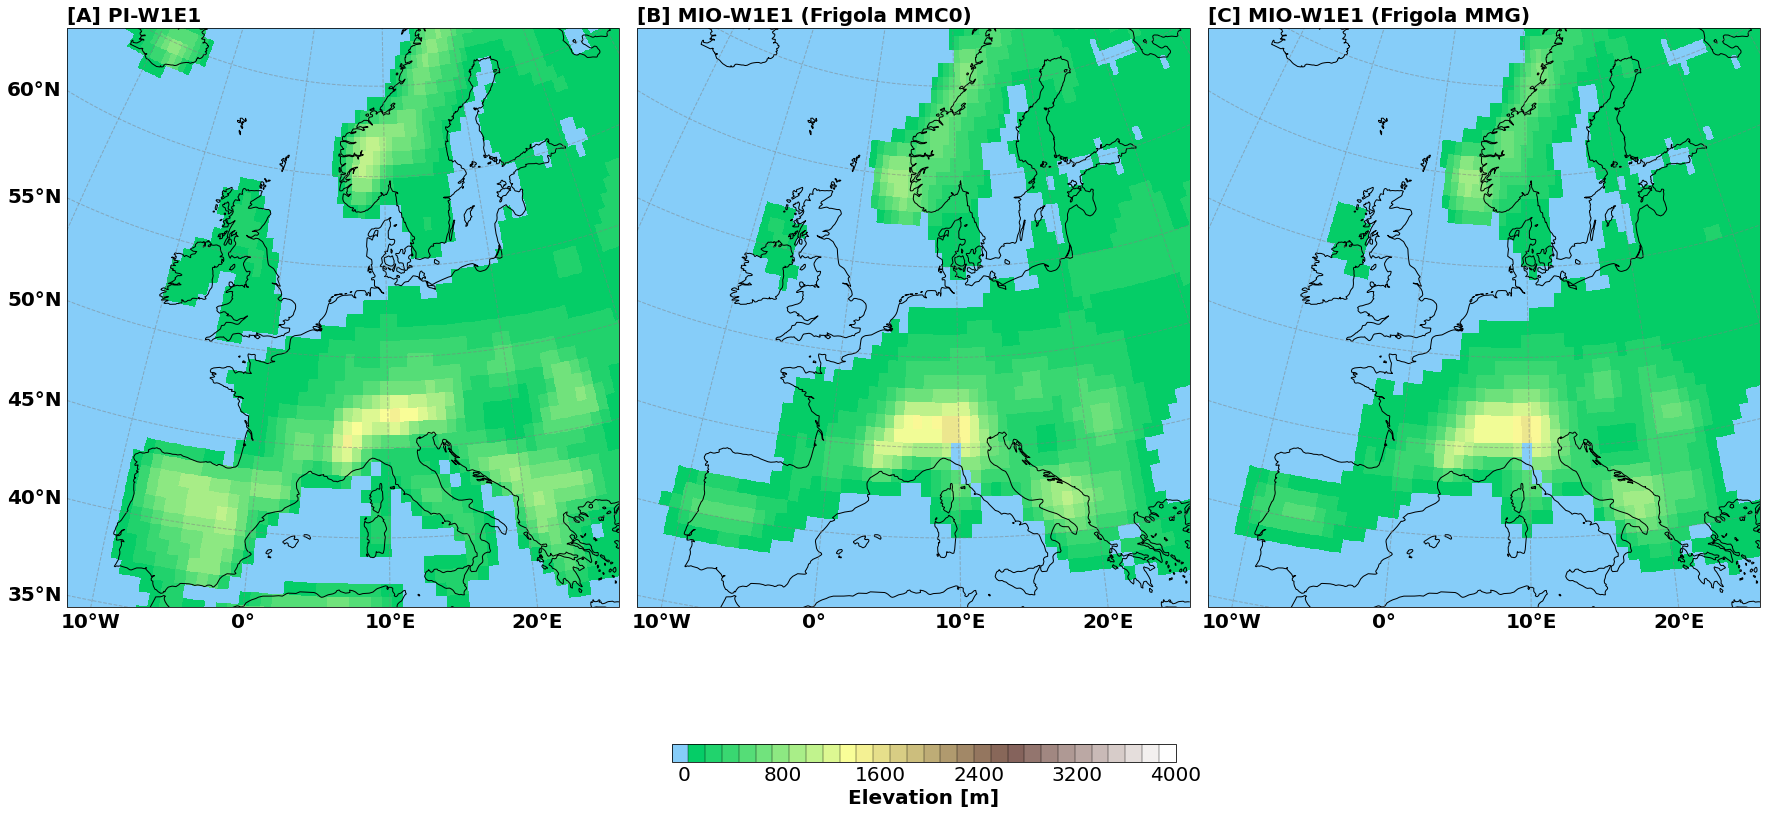

In [12]:
projection = ccrs.EuroPP()
fig, (ax1,ax2,ax3) = plt.subplots(nrows = 1, ncols = 3, figsize=(28, 13), 
                                                    subplot_kw={"projection": projection})


pi_oromea = read_jan_surf_oromea(path_to_t159, "T159_PI_W1E1_jan_surf.nc")
plot_echam_topo(variable="Elevation", data=pi_oromea, cmap=terrain_shift, units="m", 
                vmax=4000, vmin=-100, levels=31, level_ticks=6,
                domain="Europe", cbar=True, cbar_position= [0.35, 0.05, 0.25, 0.02], cbar_orientation="horizontal",
                projection=projection, norm=norm_new, plot_coastlines=True, plot_borders=False, ax=ax1, 
                title="[A] PI-W1E1", bottom_labels=True, fig=fig)

mio278_oromea = read_jan_surf_oromea(path_to_mio278, "T159_MIO_278ppm_jan_surf_Frigola.nc")

plot_echam_topo(variable="Elevation", data=mio278_oromea, cmap=terrain_shift, units="m", 
                vmax=4000, vmin=-100, levels=31, level_ticks=6,
                domain="Europe", cbar=False, projection=projection, norm=norm_new, plot_coastlines=True, plot_borders=False, 
                ax=ax2, title="[B] MIO-W1E1 (Frigola MMC0)", bottom_labels=True, left_labels=False)

mio450_oromea = read_jan_surf_oromea(path_to_mio450, "T159_MIO_450ppm_jan_surf_Frigola.nc")

plot_echam_topo(variable="Elevation", data=mio450_oromea, cmap=terrain_shift, units="m", 
                vmax=4000, vmin=-100, levels=31, level_ticks=6,
                domain="Europe", cbar=False, projection=projection, norm=norm_new, plot_coastlines=True, plot_borders=False, 
                ax=ax3, title="[C] MIO-W1E1 (Frigola MMG)", bottom_labels=True, left_labels=False)

fig.canvas.draw()   # the only way to apply tight_layout to matplotlib and cartopy is to apply canvas firt 
plt.tight_layout() 
plt.subplots_adjust(left=0.05, right=0.89, top=0.95, bottom=0.10)
#plt.savefig(os.path.join(path_to_store, "topography_mio_frigola.png"), format= "png", bbox_inches="tight", dpi=300)
plt.show()